# A comment on Kirill Kalinin's text in Meduza   
**Dmitry Kobak and Maxim Pschenichnikov**

Kirill's text:  
https://meduza.io/feature/2018/05/07/issledovatel-iz-stenforda-schitaet-chto-falsifikatsiy-na-vyborah-prezidenta-rossii-bylo-ochen-malo-kak-on-eto-vychislil

https://meduza.io/en/feature/2018/05/09/a-researcher-at-stanford-university-says-there-was-very-little-falsification-in-putin-s-latest-re-election-and-here-s-how-he-crunched-those-numbers

Our comment:  
*upcoming*

This notebook provides all the analysis code for our reply, and some supporting information.

In [1]:
# Load libraries and set up notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
from zipfile import ZipFile
import pickle
import time

import matplotlib as mpl
mpl.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

from IPython.display import display

In [2]:
# Load data for a given year

def loaddata(year):
    zip_file = ZipFile('electionsData.zip')
    
    table = pd.read_csv(zip_file.open('{}.txt'.format(year)), sep='\t')
        
    colFilter = ['ПУТИН', 'Путин', 'Единая Россия', 'ЕДИНАЯ РОССИЯ', 'Медведев']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    leader = np.squeeze(table[col].values)
    
    colFilter = ['Число избирателей, включенных', 'Число избирателей, внесенных']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    voters = np.squeeze(table[col].values)
    
    colFilter = ['бюллетеней, выданных']                # should select 3 columns
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    given = np.sum(table[col].values, axis=1)

    colFilter = ['действительных', 'недействительных']  # should select 2 columns
    excludeFilter = ['отметок']  # excludes one additional column in the 2000 data
    col = [col for col in table.columns if any([f in col for f in colFilter]) and 
                                           all([f not in col for f in excludeFilter])]
    received = np.sum(table[col].values, axis=1)
    
    regions = table['region'].values
    tiks = table['tik'].values
    uiks = table['uik'].values
    
    return (voters, given, received, leader, regions, tiks, uiks)

# Turnout histogram in 2018

For previous years, see https://github.com/dkobak/elections/blob/master/elections2018.ipynb

<IPython.core.display.Javascript object>


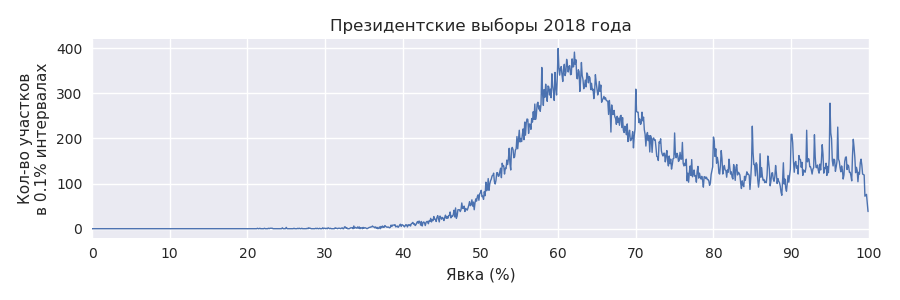

In [4]:
year     = 2018        
binwidth = 0.1         

voters, given, received, leader = loaddata(year)[:4]

ind = (received > 0) & (given < voters)
edges = np.arange(-binwidth/2, 100, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.random.rand(np.sum(ind)) - .5
h = np.histogram(100 * (given[ind]+noise)/voters[ind], bins=edges)[0]

sns.set()
plt.figure(figsize=(9,3))
plt.plot(centers, h, linewidth=1)
plt.xlabel("Явка (%)")
plt.ylabel('Кол-во участков\nв 0.1% интервалах')
plt.xticks(np.arange(0,101,10))
plt.xlim([0,100])
plt.title('Президентские выборы 2018 года')
plt.tight_layout()

# Integer anomaly

<IPython.core.display.Javascript object>


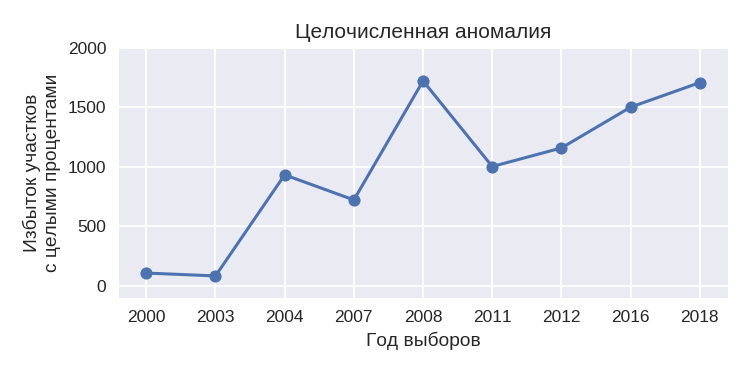

In [15]:
# Monte Carlo simulation is performed in elections2018.ipynb. 
# Here we load the results from the .pickle file

with open('montecarlo.pickle', 'rb') as f:
    [anomalies, stds, prctls] = pickle.load(f)
    years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018])
    
#sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})
sns.set()
plt.figure(figsize=(6,3))
plt.plot(anomalies[:,0,0], '-o')
plt.title('Целочисленная аномалия')
plt.ylabel('Избыток участков\nс целыми процентами')
plt.xlabel('Год выборов')
plt.ylim([-100, 2000])
plt.xticks(np.arange(years.size), years)
# sns.despine(trim=True)
plt.tight_layout()

# The model from Klimek et al.

http://www.pnas.org/content/109/41/16469.short

In [5]:
# Get Klimek PNAS fits

from scipy.stats import gaussian_kde

years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018]
klimekfits = dict(zip(years, [None for y in years]))
klimek_alphas = [2.5, 2.2, 2.3, 1.5]         # values taken from the paper
klimek_fis = [0.31, 0.636, 0.64, 0.39]       # values taken from the paper
klimek_fes = [0.009, 0.038, 0.033, 0.021]    # values taken from the paper

x = np.arange(0, 1, .001)
for i, year in enumerate([2003, 2007, 2011, 2012]):
    voters, given, received, leader = loaddata(year)[:4]
    t = given[received>0]/voters[received>0]
    v = leader[received>0]/received[received>0]
    klimekfits[year] = {}
    # First local maximum of turnout
    ind = np.where((x[:-1]>.3) & (np.diff(gaussian_kde(t).evaluate(x))<0))[0][0]
    klimekfits[year]['tau'] = x[ind]
    # First local maximum of result
    ind = np.where((x[:-1]>.3) & (np.diff(gaussian_kde(v).evaluate(x))<0))[0][0]
    klimekfits[year]['nu']  = x[ind]
    t = t - klimekfits[year]['tau']
    v = v - klimekfits[year]['nu']
    klimekfits[year]['sigma_tau'] = np.sqrt(np.mean(t[(t<0) & (v<0)]**2))
    klimekfits[year]['sigma_nu']  = np.sqrt(np.mean(v[v<0]**2))          # sqrt(2) must be a typo
    klimekfits[year]['theta']     = np.sqrt(np.sqrt(np.mean(v[v>0]**2))) # yes, double sqrt
    klimekfits[year]['f_i']   = klimek_fis[i]
    klimekfits[year]['f_e']   = klimek_fes[i]
    klimekfits[year]['alpha'] = klimek_alphas[i]
    
display(pd.DataFrame.from_dict(klimekfits))

,2000,2003,2004,2007,2008,2011,2012,2016,2018
alpha,None,2.500000,None,2.200000,None,2.300000,1.500000,None,None
f_e,None,0.009000,None,0.038000,None,0.033000,0.021000,None,None
f_i,None,0.310000,None,0.636000,None,0.640000,0.390000,None,None
nu,None,0.314000,None,0.610000,None,0.324000,0.600000,None,None
sigma_nu,None,0.081792,None,0.098875,None,0.069723,0.091970,None,None
sigma_tau,None,0.099320,None,0.069873,None,0.081381,0.069407,None,None
tau,None,0.540000,None,0.561000,None,0.529000,0.605000,None,None
theta,None,0.466479,None,0.425573,None,0.559001,0.418900,None,None


In [53]:
# Simulate Klimek's model

from scipy.stats import truncnorm

def truncnormal(a, b, mu, sigma, size):
    a, b = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.rvs(a, b, mu, sigma, size)

def simulateklimek(voters, params, seed=42):
    np.random.seed(seed)
    
    n = np.size(voters)
    simulated_turnout = truncnormal(0, 1, params['tau'], params['sigma_tau'], (n,))
    simulated_result  = truncnormal(0, 1, params['nu'],  params['sigma_nu'],  (n,))

    f = np.random.uniform(size=(n,))
    xi = np.zeros_like(f)
    fraud_ind = (f <= params['f_i'])
    xi[fraud_ind] = truncnormal(0, 1, 0, params['theta'], size=(np.sum(fraud_ind),))
    fraud_ind = (f > params['f_i']) & (f <= params['f_i']+params['f_e'])
    xi[fraud_ind] = 1 - truncnormal(0, 1, 0, 0.075, size=(np.sum(fraud_ind),))
    
    a = np.ones_like(xi) * params['alpha']
    a[fraud_ind] = 1

    leader = voters * (simulated_turnout*simulated_result + 
                       xi * (1-simulated_turnout) + 
                       xi**a * (1-simulated_result) * simulated_turnout) # xi**params['alpha'] * 
    given = voters - voters * (1 - xi) * (1 - simulated_turnout)
    return (given/voters, leader/given)

<IPython.core.display.Javascript object>


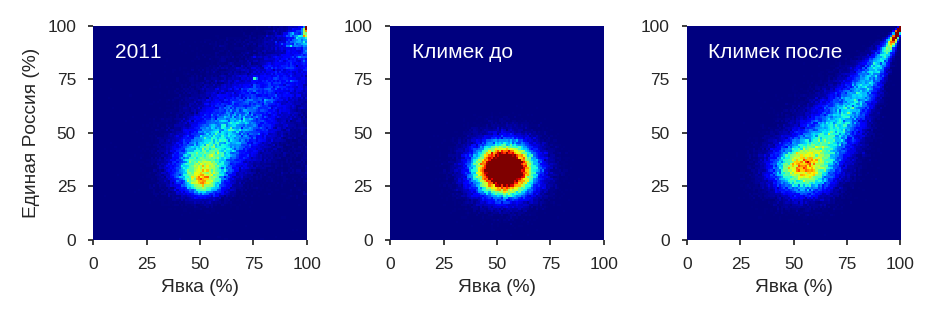

In [33]:
# Illustration: how the model works

binwidth = 1
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

year = 2011
voters, given, received, leader = loaddata(year)[:4]
ind = (received > 0) & (voters >= 100)
h = [None, None, None]

h[0] = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], bins=edges)[0]

klimek_honest = klimekfits[year].copy()
klimek_honest['f_i'] = 0
klimek_honest['f_e'] = 0
t,v = simulateklimek(voters[ind], klimek_honest)
h[1] = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

t,v = simulateklimek(voters[ind], klimekfits[year])
h[2] = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

plt.figure(figsize=(2.5*3,2.5))
for j in range(3):
    plt.subplot(1, 3, j+1)
    plt.imshow(h[j].T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('jet'), interpolation='none')
    plt.tick_params(length=3, direction='out')
    plt.xlabel('Явка (%)')
    plt.xticks([0, 25,50,75,100])
    if j == 0:
        plt.ylabel('Единая Россия (%)')
        plt.yticks([0, 25,50,75,100])
    else:
        plt.yticks([])
    plt.yticks([0, 25,50,75,100])
    plt.gca().grid(False)
        
    if j == 0: plt.text(10, 85, year,     color='w')
    if j == 1: plt.text(10, 85, 'Климек до', color='w')
    if j == 2: plt.text(10, 85, 'Климек после', color='w')
    
plt.tight_layout()

<IPython.core.display.Javascript object>


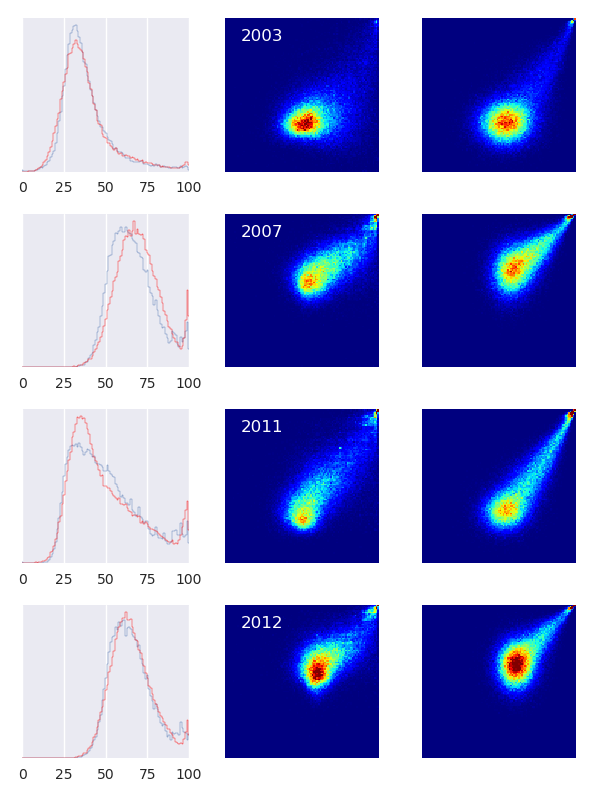

In [54]:
# Reproducing Figure S2 from Klimek et al.
# This is to make sure that my simulation code works correctly

binwidth = 1
edges = np.arange(-binwidth/2, 100+binwidth/2*3, binwidth)
centers = np.arange(0,100+binwidth,binwidth)

plt.figure(figsize=(2*3, 2*4))
for i,year in enumerate([y for y in years if klimekfits[y] is not None]):
    voters, given, received, leader = loaddata(year)[:4]
    
    # Klimek et al. removed all polling stations with <100 voters
    ind = (received > 0) & (voters >= 100) & (given < voters)
    t,v = simulateklimek(voters[ind], klimekfits[year])

    plt.subplot(4, 3, 1 + i*3)
    plt.hist(100 * leader[ind]/received[ind], histtype='step', bins=edges)
    plt.hist(100 * v, histtype='step', bins=edges, color='r')
    plt.xlim([0,100])
    plt.yticks([])
    
    plt.subplot(4, 3, 2 + i*3)
    h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], bins=edges)[0]
    plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('jet'), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.text(10, 85, year, color='w')
    
    plt.subplot(4, 3, 3 + i*3)
    h = np.histogram2d(100 * t, 100 * v, bins=edges)[0]
    plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('jet'), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')    

plt.tight_layout()

# Compare Klimek's and Mebane's fits

In [7]:
# Load Mebane's fits (data provided by Walter Mebane)

betas = pd.read_csv('mebane-kalinin.txt', sep='\t', index_col=0)
display(betas)

mebanefits = {}
for year in [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016]:
    mebanefits[year] = {}
    for param in list(betas.index):
        mebanefits[year][param] = betas.loc[param, str(year)]
mebanefits[2018] = None

,2000,2003,2004,2007,2008,2011,2012,2016
f_i,0.033104,0.157273,0.049295,0.039895,0.013020,0.120942,0.084398,0.221630
f_e,0.000032,0.003252,0.000087,0.000160,0.000002,0.003226,0.002042,0.021920
alpha,3.334111,3.334111,1.667556,1.667556,1.667556,1.755556,3.411111,1.667556
tau,0.711283,0.583640,0.692308,0.671109,0.755319,0.605785,0.652860,0.478814
nu,0.536609,0.357955,0.715403,0.660551,0.701884,0.481482,0.651276,0.491272
sigma_nu,0.157677,0.118856,0.132726,0.137326,0.120471,0.154413,0.129154,0.129822
sigma_tau,0.110259,0.133212,0.134965,0.135348,0.170760,0.134852,0.110636,0.125172
theta,0.709232,0.265968,0.443274,0.531926,0.531926,0.354621,0.354634,0.265968


In [22]:
# Official turnout vs Mebane's \tau ("true" turnout)

years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016]
for i,y in enumerate(years):
    voters, given, received, leader = loaddata(y)[:4]
    print('{}: official turnout {:2.1f}%, Mebane-Kalinin {:2.1f}%'.format(y, 
                                   100 * np.sum(given)/np.sum(voters), 
                                   100 * mebanefits[y]['tau']))

2000: official turnout 68.9%, Mebane-Kalinin 71.1%
2003: official turnout 55.7%, Mebane-Kalinin 58.4%
2004: official turnout 64.4%, Mebane-Kalinin 69.2%
2007: official turnout 63.8%, Mebane-Kalinin 67.1%
2008: official turnout 69.8%, Mebane-Kalinin 75.5%
2011: official turnout 60.2%, Mebane-Kalinin 60.6%
2012: official turnout 65.3%, Mebane-Kalinin 65.3%
2016: official turnout 47.9%, Mebane-Kalinin 47.9%


<IPython.core.display.Javascript object>


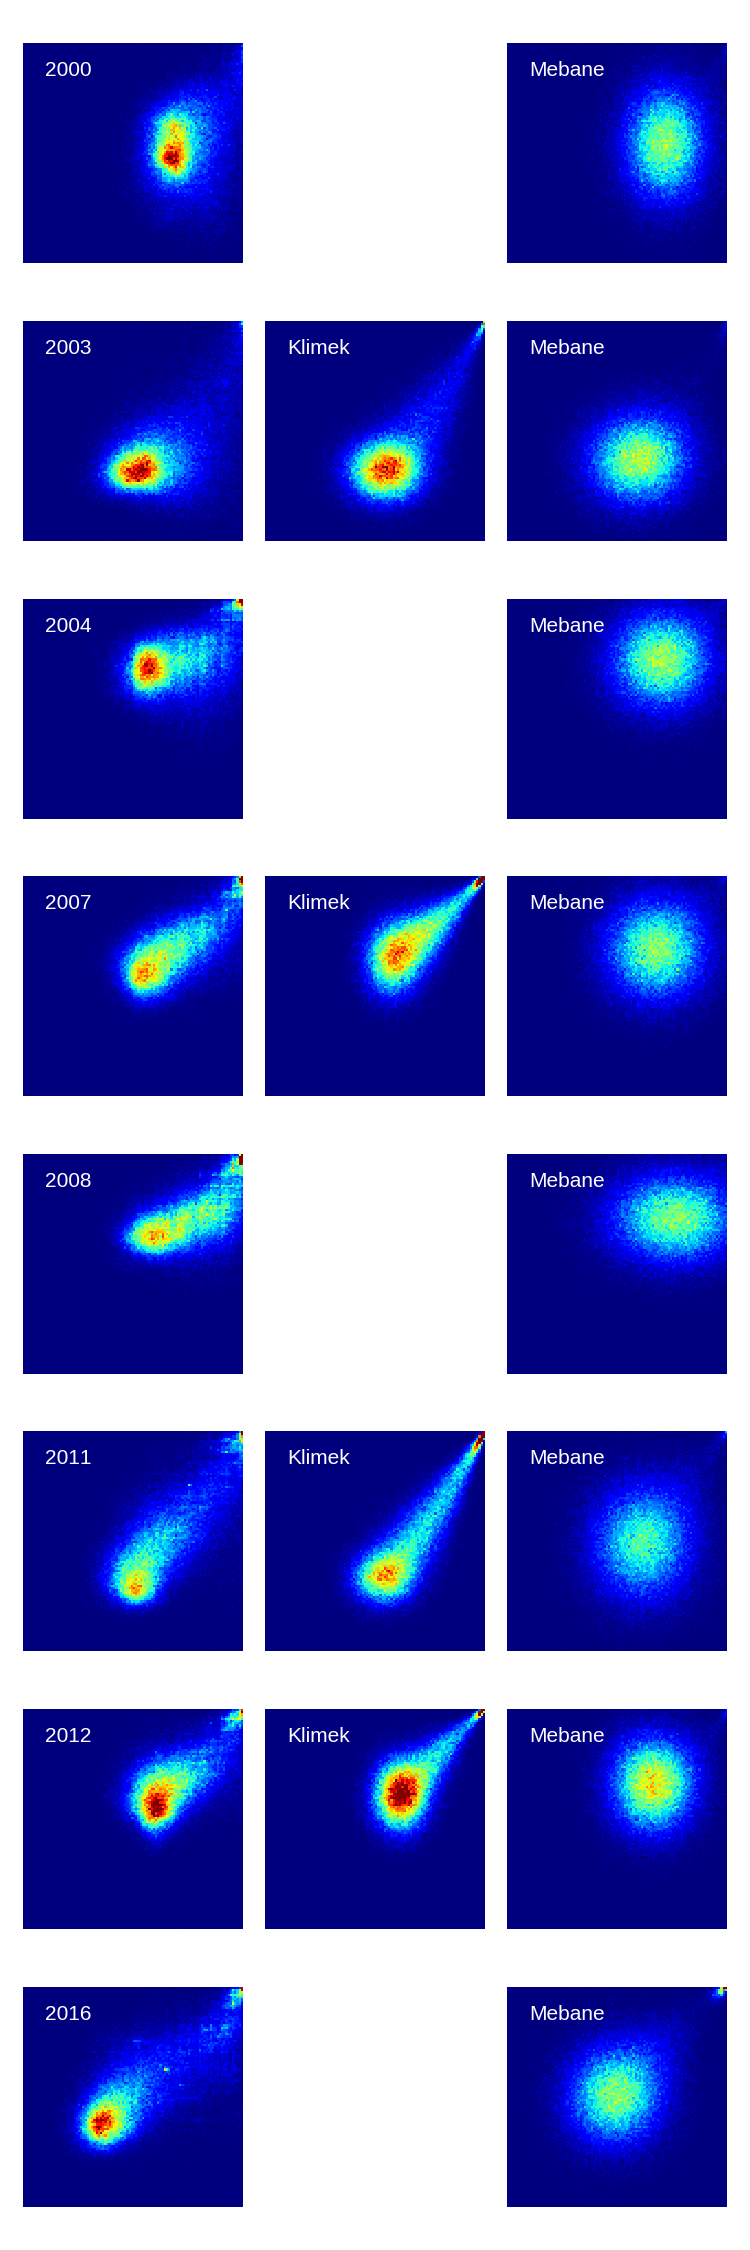

In [23]:
# Compare the data, Klimek's fits and Mebane-Kalinin fits for all years
# (using arguably suboptimal 'jet' color scheme because that's what Klimek used)

binwidth = 1
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

plt.figure(figsize=(2*3,2*9))
for i,year in enumerate(years):
    voters, given, received, leader = loaddata(year)[:4]
    
    ind = (received > 0) & (voters >= 100)
    h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], bins=edges)[0]
       
    plt.subplot(np.size(years), 3, 1 + i*3)
    plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('jet'), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.text(10, 85, year, color='w')
    
    if klimekfits[year] is not None:
        t,v = simulateklimek(voters[ind], klimekfits[year])
        h = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

        plt.subplot(np.size(years), 3, 2 + i*3)
        plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('jet'), interpolation='none')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.text(10, 85, 'Klimek', color='w')
        
    if mebanefits[year] is not None:
        t,v = simulateklimek(voters[ind], mebanefits[year])
        h = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

        plt.subplot(np.size(years), 3, 3 + i*3)
        plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('jet'), interpolation='none')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.text(10, 85, 'Mebane', color='w')
    
plt.tight_layout()

<IPython.core.display.Javascript object>


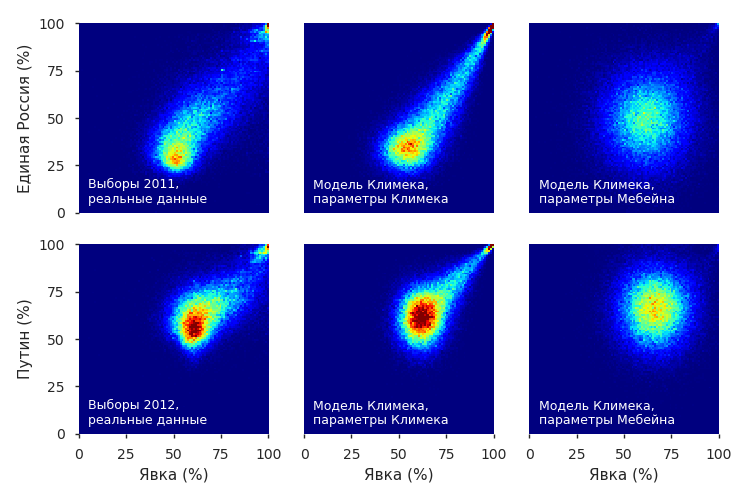

In [17]:
# The same for 2011 and 2012 (figure for Meduza)

binwidth = 1
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

plt.figure(figsize=(2.5*3,2.5*2))
ylabels = ['Единая Россия (%)', 'Путин (%)']
for i,year in enumerate([2011, 2012]):
    voters, given, received, leader = loaddata(year)[:4]
    
    ind = (received > 0) & (voters >= 100)
    h = [None, None, None]
    h[0] = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], bins=edges)[0]
    t,v = simulateklimek(voters[ind], klimekfits[year])
    h[1] = np.histogram2d(100 * t, 100 * v, bins=edges)[0]
    t,v = simulateklimek(voters[ind], mebanefits[year])
    h[2] = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

    for j in range(3):
        plt.subplot(2, 3, j + i*3 + 1)
        plt.imshow(h[j].T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
                   cmap=plt.get_cmap('jet'), interpolation='none')
        plt.tick_params(length=3, direction='out')
        if i==1:
            plt.xlabel('Явка (%)')
            plt.xticks([0, 25,50,75,100])
        else:
            plt.xticks([])
        if j==0:
            plt.ylabel(ylabels[i])
            plt.yticks([0, 25,50,75,100])
        else:
            plt.yticks([])
        plt.gca().grid(False)
        
        if j == 0: plt.text(5, 5, 'Выборы {},\nреальные данные'.format(year), color='w', fontsize=9)
        if j == 1: plt.text(5, 5, 'Модель Климека,\nпараметры Климека',      color='w', fontsize=9) 
        if j == 2: plt.text(5, 5, 'Модель Климека,\nпараметры Мебейна',      color='w', fontsize=9)
    
plt.tight_layout()

# Appendix. Koibatost in Bashkortostan

There were KOIBs in every TIK. So for each TIK we can take the turnout and result across all polling stations with KOIBs and extrapolate those to the whole TIK. Then we sum up extrapolated ballots across all TIKs. Then we compute the difference between the actual number of leader's ballots and the extrapolated number.  

In [39]:
voters, given, received, leader, regions, tiks, uiks = loaddata(2018)

# The list from http://www.vybory.izbirkom.ru/region/adygei?action=downloadNpa&region=3&vrn=20220001943769
# The link from https://podmoskovnik.livejournal.com/177878.html
koib = [10, 11, 13, 14, 54, 55, 59, 64, 95, 109, 115, 118, 131, 142, 170, 172,
176, 195, 209, 235, 239, 278, 3485, 322, 329, 345, 346, 353,
361, 365, 398, 363, 388, 430, 433, 440, 444, 445, 463, 476, 492, 496,
508, 516, 523, 535, 537, 561, 600, 601, 615, 628, 631, 640, 641, 716,
664, 681, 690, 765, 766, 767, 768, 821, 826, 827, 828, 870, 871, 899,
902, 979, 980, 981, 982, 997, 998, 1036, 1037, 1080, 1081, 1124,
1161, 1163, 1187, 1189, 1200, 1217, 1256, 1247, 1284, 1290,
1294, 1334, 1361, 1364, 1403, 1404, 1406, 1415, 1445, 1474,
1483, 1490, 1492, 1495, 1530, 1531, 1532, 1579, 1580, 1658,
1660, 1664, 1665, 1666, 1668, 1712, 1713, 1720, 1722, 1754,
1756, 1758, 1804, 1825, 1828, 1842, 1878, 1880, 1930, 1931,
1997, 2009, 2024, 2029, 2042, 2047, 2107, 2116, 2117, 2137,
2146, 3468, 3470, 2187, 2218, 2225, 2245, 2273, 2275, 2291,
2298, 2326, 2327, 2366, 2382, 2387, 2388, 2414, 2452, 2453,
2456, 2499, 2500, 2565, 2568, 2592, 2602, 2604, 2606, 2656,
2657, 2723, 2726, 2727, 2771, 2772, 2779, 2806, 2836, 2837,
2869, 2875, 2876, 2903, 2931, 2933, 2972, 2979, 2987, 3030,
3061, 3075, 3076, 3077, 3505, 3103, 3132, 3136, 3147, 3178,
3190, 3204, 3210, 3213, 3252, 3253, 3258, 3333, 3334, 3354,
3360, 3399, 3400, 3415, 3416, 3417, 3451]

ifkoib = np.array([u in koib for u in uiks])
estimate = 0
for t in np.unique(tiks[regions=='Республика Башкортостан']):
    ind = (tiks==t) & ifkoib
    if np.sum(ind) > 0:
        frac = np.sum(leader[ind]) / np.sum(voters[ind])
        ind = (tiks==t)
        estimate += np.sum(voters[ind]) * frac
    else:
        print('TIK without koibs detected')
    
ind = (regions=='Республика Башкортостан')
print('Республика Башкортостан')
print('Голосов за Путина:', np.sum(leader[regions=='Республика Башкортостан']))
print('Кол-во ТИК:', np.unique(tiks[regions=='Республика Башкортостан']).size)
print('Коибатость: {:0.0f} голосов'.format(np.sum(leader[ind]) - estimate))

Республика Башкортостан
Голосов за Путина: 1784626
Кол-во ТИК: 69
Коибатость: 321336 голосов
